In [1]:
import torch
from model import Model

DEVICE = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
model = Model().to(DEVICE)

In [ ]:
import numpy as np
from dataset import MyDataset
from torch.utils.data import DataLoader

raw_data = np.load('dataset.npy')
dataset = MyDataset(raw_data, device=DEVICE)
dataloader = DataLoader(dataset, batch_size=len(dataset))

import os
model_files = []
for r, ds, fs in os.walk('models'):
    for f in fs:
        model_files.append(os.path.join(r, f))

metric_acc = []
metric_prec = []
metrix_rcl = []
metric_f1 = []

for path in model_files:
    model.load_state_dict(torch.load(path))
    model.eval()
    loss, acc, prec, rcl, f1 = model.validate(dataloader)
    metric_acc.append(acc)
    metric_prec.append(prec)
    metrix_rcl.append(rcl)
    metric_f1.append(f1)

print(metric_f1)
idx = np.argmax(metric_f1)
metric_f1[idx], model_files[idx]

In [22]:
import numpy as np
from utils import preprocess

dn_list, tn_list, hn_list, annot, date = preprocess("dataset/new/test.csv")

In [27]:
N = 18

preds = []
labels = []
pred_date = []

model = Model().to(DEVICE)
# model.load_state_dict(torch.load(model_files[idx]))
model.load_state_dict(torch.load('models/1200_model.pt'))
model.eval()

for i in range(len(dn_list) - (N - 1)):
    data = []
    data.append(dn_list[i:i+N])
    data.append(tn_list[i:i+N])
    data.append(hn_list[i:i+N])
    data_T = np.array(data).T

    pred_date.append(date[i:i+N][N - 1])
    labels.append(annot[i:i+N][N - 1])
    data_tensor = torch.tensor(data_T).float().unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        out = model(data_tensor)[0]
    val = out.item()
    preds.append(val if val > 0.5 else 0)
    # preds.append(val)

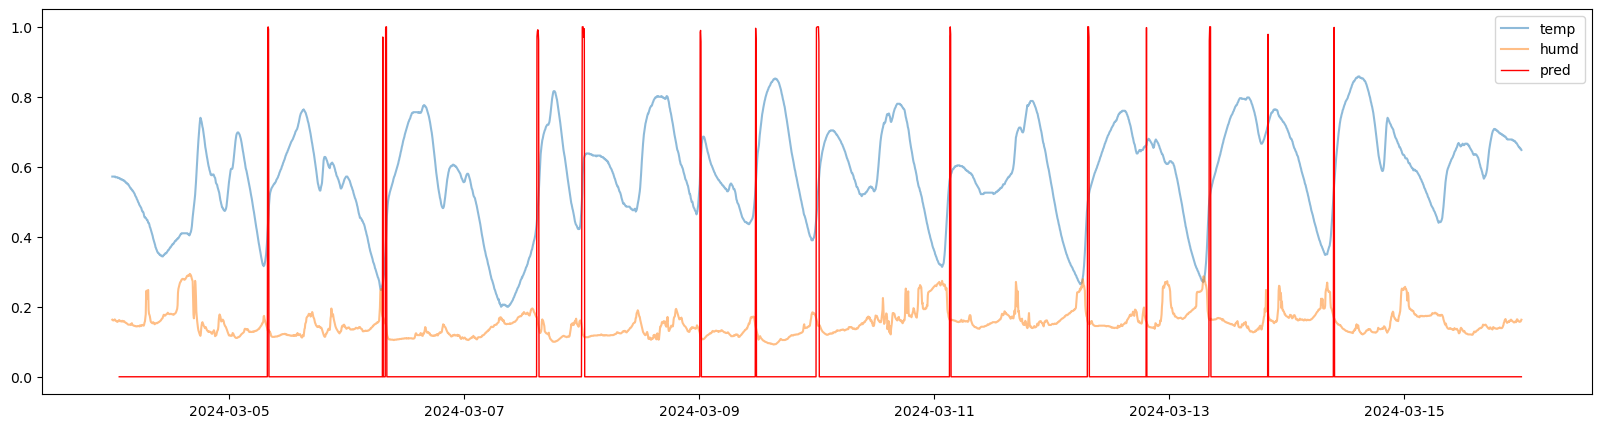

In [28]:
import matplotlib.pyplot as plt
start = 0
end = 5000
plt.figure(figsize=[20, 5])
plt.plot(date[start:end], tn_list[start:end], alpha=0.5, label='temp')
plt.plot(date[start:end], hn_list[start:end], alpha=0.5, label='humd')
# plt.plot(pred_date[start:end], labels[start:end], alpha=1,linewidth=3, label='label', c='b')
plt.plot(pred_date[start:end], preds[start:end], alpha=1, linewidth=1, label='pred', c='r')
plt.legend()